In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from math import sin, cos, sqrt, atan2
from datetime import datetime
from shapely.geometry import Point, LineString
import matplotlib.pyplot as plt
import geopandas as gpd
import pytz
import unicodedata
import random as random
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

df  = pd.DataFrame(pd.read_csv("all-data_clean.csv",encoding="utf-8"))
df

,id,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,dist_meters,wait_sec
0,1,Quito,2016-09-17 09:32:06,2016-09-17 10:05:51,0.632055,0.528947,-78.549447,-0.361363,N,2025,24228,346
1,2,Guadalajara Easy Taxi,2016-09-17 09:59:54,2016-09-17 10:06:23,0.327804,0.391950,-103.366600,20.686971,N,389,2962,3675
2,3,Monterrey,2016-09-17 10:06:52,2016-09-17 10:09:40,0.140910,0.563280,-100.165737,25.619387,N,168,951,0
3,4,Monterrey,2016-09-17 09:45:56,2016-09-17 10:13:34,0.207565,0.590416,-100.491721,25.676294,N,1659,11082,358
4,5,Monterrey,2016-09-17 10:12:00,2016-09-17 10:16:31,0.128881,0.580419,-100.104166,25.643862,N,272,2021,3614
...,...,...,...,...,...,...,...,...,...,...,...,...
90282,90283,Quito,2016-10-25 04:58:55,2016-10-25 05:00:25,0.706498,0.552770,-78.550306,-0.256756,N,91,43,70
90283,90284,Bogotá,2016-10-26 04:27:39,2016-10-28 06:50:28,0.369432,0.762872,-74.050725,4.714622,N,138169,5934,354
90284,90285,México DF Taxi de Sitio,2016-10-28 06:49:41,2016-10-28 06:51:25,0.089643,0.308893,-99.194622,19.396717,N,104,49,96
90285,90286,Quito,2016-10-28 06:47:59,2016-10-28 06:58:31,0.431407,0.724499,-78.446296,-0.327428,N,633,3296,150


In [2]:
# Assuming df is your original DataFrame
df = df.drop(columns=['store_and_fwd_flag', 'id']).sample(n=1000, random_state=42)

# If you want to reset the index after sampling
df = df.reset_index(drop=True)
df

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec
0,México DF Taxi Libre,2017-05-26 08:25:25,2017-05-26 08:37:32,0.092023,0.341753,-99.176348,19.490136,728,5941,121
1,Monterrey UberX,2017-06-20 08:40:28,2017-06-20 09:02:36,0.193704,0.644806,-100.291855,25.771030,1329,13951,340
2,México DF Taxi Libre,2016-11-20 11:16:17,2016-11-20 11:39:02,0.011786,0.251330,-99.060190,19.307505,1365,5605,731
3,Aguascalientes,2017-03-18 06:18:17,2017-03-18 06:53:59,0.237326,0.510964,-102.306885,21.846671,2142,14594,640
4,México DF Taxi de Sitio,2017-07-05 03:07:37,2017-07-05 07:11:11,0.065864,0.319107,-99.161885,19.411457,14615,2929,696
...,...,...,...,...,...,...,...,...,...,...
995,Guadalajara,2016-12-20 02:00:54,2016-12-20 02:17:32,0.334488,0.399370,-103.431862,20.749699,998,8098,177
996,Monterrey,2016-11-09 08:32:48,2016-11-09 08:39:12,0.194494,0.605561,-100.367010,25.659974,385,2656,293
997,Aguascalientes,2017-01-30 01:19:39,2017-01-30 01:33:13,0.298699,0.486486,-102.281478,21.935503,815,6822,199
998,Quito,2017-01-19 11:35:08,2017-01-19 11:54:02,0.460692,0.136427,-78.491188,-0.194382,1135,5912,426


In [3]:
def calculate_distance(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two points on the Earth's surface using the Haversine formula.

    Parameters:
    - lat1 (float): Latitude of the first point.
    - lon1 (float): Longitude of the first point.
    - lat2 (float): Latitude of the second point.
    - lon2 (float): Longitude of the second point.

    Returns:
    float: The distance between the two points in kilometers.
    """
    R = 6371  # Radius of Earth in kilometers
    dlat = np.radians(lat2 - lat1)
    dlon = np.radians(lon2 - lon1)
    
    a = np.sin(dlat / 2) * np.sin(dlat / 2) + np.cos(np.radians(lat1)) * np.cos(np.radians(lat2)) * np.sin(dlon / 2) * np.sin(dlon / 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    distance = R * c
    return distance


for i in range(len(df)):
    df.at[i,'dist_long_lat'] = calculate_distance(df.at[i,'pickup_latitude'], df.at[i,'pickup_longitude'], df.at[i,'dropoff_latitude'], df.at[i,'dropoff_longitude'])

df

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,dist_long_lat
0,México DF Taxi Libre,2017-05-26 08:25:25,2017-05-26 08:37:32,0.092023,0.341753,-99.176348,19.490136,728,5941,121,10965.766066
1,Monterrey UberX,2017-06-20 08:40:28,2017-06-20 09:02:36,0.193704,0.644806,-100.291855,25.771030,1329,13951,340,11024.744907
2,México DF Taxi Libre,2016-11-20 11:16:17,2016-11-20 11:39:02,0.011786,0.251330,-99.060190,19.307505,1365,5605,731,10949.775035
3,Aguascalientes,2017-03-18 06:18:17,2017-03-18 06:53:59,0.237326,0.510964,-102.306885,21.846671,2142,14594,640,11279.135743
4,México DF Taxi de Sitio,2017-07-05 03:07:37,2017-07-05 07:11:11,0.065864,0.319107,-99.161885,19.411457,14615,2929,696,10962.886439
...,...,...,...,...,...,...,...,...,...,...,...
995,Guadalajara,2016-12-20 02:00:54,2016-12-20 02:17:32,0.334488,0.399370,-103.431862,20.749699,998,8098,177,11421.070944
996,Monterrey,2016-11-09 08:32:48,2016-11-09 08:39:12,0.194494,0.605561,-100.367010,25.659974,385,2656,293,11035.362514
997,Aguascalientes,2017-01-30 01:19:39,2017-01-30 01:33:13,0.298699,0.486486,-102.281478,21.935503,815,6822,199,11282.972793
998,Quito,2017-01-19 11:35:08,2017-01-19 11:54:02,0.460692,0.136427,-78.491188,-0.194382,1135,5912,426,8779.111574


In [4]:
def CalculateSpeed(trip_duration, dist_meters):
    return dist_meters * 0.001 * 3600 / trip_duration

for i in range(len(df)):
    df.loc[i,'driver_avg_speed'] = CalculateSpeed(df.loc[i,'trip_duration'], df.loc[i,'dist_meters'])

df

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,dist_long_lat,driver_avg_speed
0,México DF Taxi Libre,2017-05-26 08:25:25,2017-05-26 08:37:32,0.092023,0.341753,-99.176348,19.490136,728,5941,121,10965.766066,29.378571
1,Monterrey UberX,2017-06-20 08:40:28,2017-06-20 09:02:36,0.193704,0.644806,-100.291855,25.771030,1329,13951,340,11024.744907,37.790519
2,México DF Taxi Libre,2016-11-20 11:16:17,2016-11-20 11:39:02,0.011786,0.251330,-99.060190,19.307505,1365,5605,731,10949.775035,14.782418
3,Aguascalientes,2017-03-18 06:18:17,2017-03-18 06:53:59,0.237326,0.510964,-102.306885,21.846671,2142,14594,640,11279.135743,24.527731
4,México DF Taxi de Sitio,2017-07-05 03:07:37,2017-07-05 07:11:11,0.065864,0.319107,-99.161885,19.411457,14615,2929,696,10962.886439,0.721478
...,...,...,...,...,...,...,...,...,...,...,...,...
995,Guadalajara,2016-12-20 02:00:54,2016-12-20 02:17:32,0.334488,0.399370,-103.431862,20.749699,998,8098,177,11421.070944,29.211222
996,Monterrey,2016-11-09 08:32:48,2016-11-09 08:39:12,0.194494,0.605561,-100.367010,25.659974,385,2656,293,11035.362514,24.835325
997,Aguascalientes,2017-01-30 01:19:39,2017-01-30 01:33:13,0.298699,0.486486,-102.281478,21.935503,815,6822,199,11282.972793,30.133988
998,Quito,2017-01-19 11:35:08,2017-01-19 11:54:02,0.460692,0.136427,-78.491188,-0.194382,1135,5912,426,8779.111574,18.751718


In [5]:
for i in range(len(df)):
    df.loc[i, 'vendor_id'] = unicodedata.normalize('NFKD', (df.loc[i, 'vendor_id'])).encode('ASCII', 'ignore').decode('utf-8')

df

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,dist_long_lat,driver_avg_speed
0,Mexico DF Taxi Libre,2017-05-26 08:25:25,2017-05-26 08:37:32,0.092023,0.341753,-99.176348,19.490136,728,5941,121,10965.766066,29.378571
1,Monterrey UberX,2017-06-20 08:40:28,2017-06-20 09:02:36,0.193704,0.644806,-100.291855,25.771030,1329,13951,340,11024.744907,37.790519
2,Mexico DF Taxi Libre,2016-11-20 11:16:17,2016-11-20 11:39:02,0.011786,0.251330,-99.060190,19.307505,1365,5605,731,10949.775035,14.782418
3,Aguascalientes,2017-03-18 06:18:17,2017-03-18 06:53:59,0.237326,0.510964,-102.306885,21.846671,2142,14594,640,11279.135743,24.527731
4,Mexico DF Taxi de Sitio,2017-07-05 03:07:37,2017-07-05 07:11:11,0.065864,0.319107,-99.161885,19.411457,14615,2929,696,10962.886439,0.721478
...,...,...,...,...,...,...,...,...,...,...,...,...
995,Guadalajara,2016-12-20 02:00:54,2016-12-20 02:17:32,0.334488,0.399370,-103.431862,20.749699,998,8098,177,11421.070944,29.211222
996,Monterrey,2016-11-09 08:32:48,2016-11-09 08:39:12,0.194494,0.605561,-100.367010,25.659974,385,2656,293,11035.362514,24.835325
997,Aguascalientes,2017-01-30 01:19:39,2017-01-30 01:33:13,0.298699,0.486486,-102.281478,21.935503,815,6822,199,11282.972793,30.133988
998,Quito,2017-01-19 11:35:08,2017-01-19 11:54:02,0.460692,0.136427,-78.491188,-0.194382,1135,5912,426,8779.111574,18.751718


In [6]:
def CalculateSlope(lat1,long1,lat2,long2):
    slope = (lat2 - lat1) / (long2 - long1)
    return(slope)

for i in range(len(df)):
    df.loc[i,'slope'] = CalculateSlope(df.loc[i,'pickup_latitude'], df.loc[i,'pickup_longitude'], df.loc[i,'dropoff_latitude'], df.loc[i,'dropoff_longitude'])

df

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,dist_long_lat,driver_avg_speed,slope
0,Mexico DF Taxi Libre,2017-05-26 08:25:25,2017-05-26 08:37:32,0.092023,0.341753,-99.176348,19.490136,728,5941,121,10965.766066,29.378571,-0.192895
1,Monterrey UberX,2017-06-20 08:40:28,2017-06-20 09:02:36,0.193704,0.644806,-100.291855,25.771030,1329,13951,340,11024.744907,37.790519,-0.250048
2,Mexico DF Taxi Libre,2016-11-20 11:16:17,2016-11-20 11:39:02,0.011786,0.251330,-99.060190,19.307505,1365,5605,731,10949.775035,14.782418,-0.192347
3,Aguascalientes,2017-03-18 06:18:17,2017-03-18 06:53:59,0.237326,0.510964,-102.306885,21.846671,2142,14594,640,11279.135743,24.527731,-0.208063
4,Mexico DF Taxi de Sitio,2017-07-05 03:07:37,2017-07-05 07:11:11,0.065864,0.319107,-99.161885,19.411457,14615,2929,696,10962.886439,0.721478,-0.192409
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Guadalajara,2016-12-20 02:00:54,2016-12-20 02:17:32,0.334488,0.399370,-103.431862,20.749699,998,8098,177,11421.070944,29.211222,-0.196117
996,Monterrey,2016-11-09 08:32:48,2016-11-09 08:39:12,0.194494,0.605561,-100.367010,25.659974,385,2656,293,11035.362514,24.835325,-0.249145
997,Aguascalientes,2017-01-30 01:19:39,2017-01-30 01:33:13,0.298699,0.486486,-102.281478,21.935503,815,6822,199,11282.972793,30.133988,-0.209095
998,Quito,2017-01-19 11:35:08,2017-01-19 11:54:02,0.460692,0.136427,-78.491188,-0.194382,1135,5912,426,8779.111574,18.751718,0.004190


In [7]:
for i in range(len(df)):
    df.loc[i,'trip_duration_hours'] = df.loc[i,'trip_duration'] / 3600

for i in range(len(df)):
    df.loc[i,'dist_kilometers'] = df.loc[i,'dist_meters'] / 1000

df

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,dist_long_lat,driver_avg_speed,slope,trip_duration_hours,dist_kilometers
0,Mexico DF Taxi Libre,2017-05-26 08:25:25,2017-05-26 08:37:32,0.092023,0.341753,-99.176348,19.490136,728,5941,121,10965.766066,29.378571,-0.192895,0.202222,5.941
1,Monterrey UberX,2017-06-20 08:40:28,2017-06-20 09:02:36,0.193704,0.644806,-100.291855,25.771030,1329,13951,340,11024.744907,37.790519,-0.250048,0.369167,13.951
2,Mexico DF Taxi Libre,2016-11-20 11:16:17,2016-11-20 11:39:02,0.011786,0.251330,-99.060190,19.307505,1365,5605,731,10949.775035,14.782418,-0.192347,0.379167,5.605
3,Aguascalientes,2017-03-18 06:18:17,2017-03-18 06:53:59,0.237326,0.510964,-102.306885,21.846671,2142,14594,640,11279.135743,24.527731,-0.208063,0.595000,14.594
4,Mexico DF Taxi de Sitio,2017-07-05 03:07:37,2017-07-05 07:11:11,0.065864,0.319107,-99.161885,19.411457,14615,2929,696,10962.886439,0.721478,-0.192409,4.059722,2.929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Guadalajara,2016-12-20 02:00:54,2016-12-20 02:17:32,0.334488,0.399370,-103.431862,20.749699,998,8098,177,11421.070944,29.211222,-0.196117,0.277222,8.098
996,Monterrey,2016-11-09 08:32:48,2016-11-09 08:39:12,0.194494,0.605561,-100.367010,25.659974,385,2656,293,11035.362514,24.835325,-0.249145,0.106944,2.656
997,Aguascalientes,2017-01-30 01:19:39,2017-01-30 01:33:13,0.298699,0.486486,-102.281478,21.935503,815,6822,199,11282.972793,30.133988,-0.209095,0.226389,6.822
998,Quito,2017-01-19 11:35:08,2017-01-19 11:54:02,0.460692,0.136427,-78.491188,-0.194382,1135,5912,426,8779.111574,18.751718,0.004190,0.315278,5.912


In [8]:
def random_shuffle(df):
    """
    Randomly shuffles the rows of the input DataFrame.

    Parameters:
    - df (DataFrame): Input DataFrame to be shuffled.

    Returns:
    DataFrame: A new DataFrame with the rows randomly shuffled.
    """
    # Convert the DataFrame to a list of rows
    rows = df.values.tolist()

    for i in range(len(df)):
        j = random.randint(0, i)
        if rows[i][9] > rows[j][9]:
            # Swap rows based on a random condition (e.g., comparing values in column 9)
            rows[i], rows[j] = rows[j], rows[i]

    # Create a new DataFrame with the shuffled rows
    shuffled_df = pd.DataFrame(rows, columns=df.columns)
    return shuffled_df

shuffled_df = random_shuffle(df)
shuffled_df

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,dist_long_lat,driver_avg_speed,slope,trip_duration_hours,dist_kilometers
0,Guadalajara Easy Taxi,2017-02-28 02:45:55,2017-02-28 03:17:14,0.336626,0.401948,-103.390951,20.761274,1879,14185,582,11416.832448,27.177222,-0.196277,0.521944,14.185
1,Aguascalientes,2017-03-18 06:18:17,2017-03-18 06:53:59,0.237326,0.510964,-102.306885,21.846671,2142,14594,640,11279.135743,24.527731,-0.208063,0.595000,14.594
2,Mexico DF Radio Taxi,2016-11-11 06:34:09,2016-11-11 07:28:34,0.069098,0.299084,-99.179611,19.371461,3266,6909,4250,10966.093057,7.615554,-0.192168,0.907222,6.909
3,Guadalajara,2016-07-06 03:53:51,2016-07-06 07:26:23,0.329574,0.394842,-103.387281,20.724564,12753,2500,12626,11416.389118,0.705716,-0.196012,3.542500,2.500
4,Mexico DF Taxi Libre,2016-12-12 01:49:45,2016-12-12 02:00:57,0.085807,0.284926,-99.191332,19.363460,673,319,600,10969.651899,1.706389,-0.192174,0.186944,0.319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Guadalajara,2016-12-20 02:00:54,2016-12-20 02:17:32,0.334488,0.399370,-103.431862,20.749699,998,8098,177,11421.070944,29.211222,-0.196117,0.277222,8.098
996,Monterrey,2016-11-09 08:32:48,2016-11-09 08:39:12,0.194494,0.605561,-100.367010,25.659974,385,2656,293,11035.362514,24.835325,-0.249145,0.106944,2.656
997,Aguascalientes,2017-01-30 01:19:39,2017-01-30 01:33:13,0.298699,0.486486,-102.281478,21.935503,815,6822,199,11282.972793,30.133988,-0.209095,0.226389,6.822
998,Quito,2016-08-29 09:09:25,2016-08-29 09:18:24,0.651880,0.201267,-78.501832,-0.203960,540,4389,141,8801.587674,29.260000,0.005119,0.150000,4.389


In [9]:
def quicksort(df):
    """
    Sorts a DataFrame using the randomized divide and conquer algorithm based on the 'dist_meters' column.

    Parameters:
    - df (DataFrame): Input DataFrame to be sorted.

    Returns:
    DataFrame: A new DataFrame with rows sorted based on the 'dist_meters' column.
    """
    if len(df) <= 1:
        return df
    else:
        # Select a random pivot from the "dist_meters" column
        pivot_index = random.randint(0, len(df) - 1)
        pivot = df.iloc[pivot_index]['dist_meters']

        # Initialize two lists for elements less than and greater than the pivot
        less_than_pivot = []
        greater_than_pivot = []

        for index, row in df.iterrows():
            if row['dist_meters'] < pivot:
                less_than_pivot.append(row)
            elif row['dist_meters'] > pivot:
                greater_than_pivot.append(row)

        # Recursively sort the two partitions
        sorted_less = quicksort(pd.DataFrame(less_than_pivot))
        sorted_greater = quicksort(pd.DataFrame(greater_than_pivot))

        return pd.concat([sorted_less, sorted_greater])

# Call the quicksort function to sort it by the 'dist_meters' column
sorted_df = quicksort(shuffled_df)

# Display the sorted DataFrame
sorted_df

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,dist_long_lat,driver_avg_speed,slope,trip_duration_hours,dist_kilometers
983,Quito,2017-02-03 08:39:13,2017-02-03 08:39:29,0.662490,0.431187,-78.513176,-0.223915,17,21,8,8804.166844,4.447059,0.008274,0.004722,0.021
599,Quito,2017-05-03 03:02:08,2017-05-05 04:52:41,0.653201,0.383856,-78.508553,-0.209820,179433,24,3,8802.580177,0.000482,0.007500,49.842500,0.024
183,Manta,2016-10-17 04:52:36,2016-10-17 04:53:22,0.772021,0.035043,-80.663639,-0.965991,47,33,34,9055.435232,2.527660,0.012292,0.013056,0.033
683,Monterrey,2017-06-10 05:19:38,2017-06-10 09:02:35,0.177247,0.601079,-100.310467,25.667766,13377,39,27,11028.138418,0.010496,-0.249450,3.715833,0.039
904,Valledupar UberX,2017-03-11 12:50:15,2017-03-11 12:50:57,0.363027,0.054761,-73.251674,10.471874,42,41,34,8215.609280,3.514286,-0.141509,0.011667,0.041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752,Guadalajara Easy Taxi,2017-02-25 05:00:33,2017-02-28 06:29:49,0.326996,0.395256,-103.434645,20.769357,221356,42043,1936,11420.546799,0.683762,-0.196355,61.487778,42.043
286,Guadalajara Easy Taxi,2016-09-23 12:00:36,2016-09-24 09:59:47,0.332511,0.397528,-103.501156,20.796037,122352,45292,1599,11427.632673,1.332640,-0.196454,33.986667,45.292
54,Monterrey,2016-08-28 12:16:47,2016-08-28 01:33:32,0.197423,0.652756,-100.106092,25.756283,4606,55456,374,11006.344755,43.343812,-0.250276,1.279444,55.456
911,Cuenca,2016-12-13 05:22:59,2016-12-13 06:22:08,0.733115,0.686943,-78.973476,-2.882680,3550,62231,260,8868.419473,63.107493,0.044785,0.986111,62.231


In [10]:
from sklearn.svm import SVR

""""normalize data, try standard deviation, SVM, SKLEARN"""
def regression_and_SVM_time_prediction(df, dist_meters, wait_sec, pickup_datetime):
    """
    Predicts the expected duration and arrival time of a trip using linear regression.

    Parameters:
    - df (DataFrame): The input DataFrame containing historical trip data.
    - dist_meters (list): List of distances in meters for new trips.
    - wait_sec (list): List of waiting times in seconds for new trips.
    - pickup_datetime (list): List of pickup datetimes for new trips.

    Returns:
    None: Prints the Mean Squared Error, Deterministic Coefficient (R-squared),
    and the expected duration and arrival time for the new trips.

    Example:
    regression_time_prediction(df, [11082], [358], ['2016-09-17 09:45:56'])
    """

    # Convert pickup_datetime to numerical values
    starting_time = pd.to_datetime(pickup_datetime)
    starting_time_sec = (starting_time - datetime(1970, 1, 1)).total_seconds()

    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['pickup_datetime_numeric'] = (df['pickup_datetime'] - datetime(1970, 1, 1)).dt.total_seconds()

    # Convert dropoff_datetime to numerical values
    df['dropoff_datetime'] = pd.to_datetime(df['dropoff_datetime'])
    df['dropoff_datetime_numeric'] = (df['dropoff_datetime'] - datetime(1970, 1, 1)).dt.total_seconds()

    # Select independent variables
    X = df[['dist_meters', 'wait_sec', 'pickup_datetime_numeric']]
    y = df['dropoff_datetime_numeric']

    # Split into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Standardize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create a linear regression model
    model = LinearRegression()

    # Fit the model to the training data
    model.fit(X_train_scaled, y_train)

    # Predict on the test data
    y_pred = model.predict(X_test_scaled)

    # Evaluate the results
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse/1000000000}")
    print(f"Deterministic Coefficient (R-squared): {r2}")

    # Predict for new data
    new_data = pd.DataFrame({'dist_meters': dist_meters, 'wait_sec': wait_sec, 'pickup_datetime': pickup_datetime})
    new_data['pickup_datetime'] = pd.to_datetime(new_data['pickup_datetime'])
    new_data['pickup_datetime_numeric'] = (new_data['pickup_datetime'] - datetime(1970, 1, 1)).dt.total_seconds()
    new_data_scaled = scaler.transform(new_data[['dist_meters', 'wait_sec', 'pickup_datetime_numeric']])

    # Make predictions
    prediction = model.predict(new_data_scaled)


    mexico_timezone = pytz.timezone('America/Mexico_City')

    print(f"Expected trip duration in minutes: ", (prediction[0] - starting_time_sec[0]) / 60.0)
    predicted_datetime = pd.to_datetime(prediction[0], unit='s', utc=True).tz_convert(mexico_timezone)
    print(f"Expected date and time of arrival: {predicted_datetime}")

    print("\n -------- SVM result ----------")
    # Create an SVR model
    model_SVM = SVR()

    # Fit the model to the training data
    model_SVM.fit(X_train_scaled, y_train)

    # Predict on the test data
    y_pred = model_SVM.predict(X_test_scaled)

    # Make predictions for new data
    prediction_SVM = model_SVM.predict(new_data_scaled)

    # Evaluate the results
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"Mean Squared Error: {mse/1000000000}")
    print(f"Deterministic Coefficient (R-squared): {r2}")
    print(f"Expected trip duration in minutes: ", (prediction_SVM[0] - starting_time_sec[0]) / 60.0)
    predicted_datetime = pd.to_datetime(prediction_SVM[0], unit='s', utc=True).tz_convert(mexico_timezone)
    print(f"Expected date and time of arrival: {predicted_datetime}")

# Calculate and print statistics on trip durations
min_trip_duration = sorted_df['trip_duration'].min()
mean_trip_duration = sorted_df['trip_duration'].mean()
max_trip_duration = sorted_df['trip_duration'].max()

print("Minimum Trip Duration:", min_trip_duration/60.0, "minutes")
print("Mean Trip Duration:", mean_trip_duration/3600.0, "hours")
print("Maximum Trip Duration:", max_trip_duration/3600.0, "hours")

print('\n ------- regression_results -------')
regression_and_SVM_time_prediction(df, [11082], [358], ['2016-09-17 09:45:56'])

Minimum Trip Duration: 0.1 minutes
Mean Trip Duration: 9.724172686618507 hours
Maximum Trip Duration: 1535.6572222222221 hours

 ------- regression_results -------
Mean Squared Error: 3.542823520561038
Deterministic Coefficient (R-squared): 0.9999632657909717
Expected trip duration in minutes:  771.4419244368871
Expected date and time of arrival: 2016-09-17 17:37:22.515466240-05:00

 -------- SVM result ----------
Mean Squared Error: 96510.76221486036
Deterministic Coefficient (R-squared): -0.00068391555644709
Expected trip duration in minutes:  183403.16950247288
Expected date and time of arrival: 2017-01-22 12:29:06.170148352-06:00


In [11]:
def calculate_eigenvalues(X):
    """
    Calculates the eigenvalues and eigenvectors of the covariance matrix of the input data.

    Parameters:
    - X (DataFrame): Input data containing numerical columns.

    Returns:
    tuple: A tuple containing eigenvalues and eigenvectors of the covariance matrix.
    """

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_meaned = X_scaled - np.mean(X_scaled, axis=0)
    cov_matrix = np.cov(X_meaned, rowvar=False)

    # Calculate the eigenvalues and eigenvectors of the matrix
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    return eigenvalues, eigenvectors

def PCA(df):
    """
    Performs Principal Component Analysis (PCA) on the input DataFrame.

    Parameters:
    - df (DataFrame): Input DataFrame containing numerical columns for PCA.

    Returns:
    None: Prints the explained variance by eigenvalues for each numerical column.
    """

    numerical_columns = ['dist_meters', 'dist_long_lat','driver_avg_speed', 'trip_duration', 'wait_sec']
    X = df[numerical_columns]

    eigenvalues, eigenvectors = calculate_eigenvalues(X)
    explained_variance = np.var(X @ eigenvectors.T, axis=0) / sum(eigenvalues)

    print("Explained Variance by eigenvalues:")

    for i, ratio in enumerate(explained_variance):
        eigenvalue_name = numerical_columns[i]
        print(f"Eigenvalue for {eigenvalue_name}: {ratio/1000000:0.2f}")

PCA(sorted_df)

Explained Variance by eigenvalues:
Eigenvalue for dist_meters: 135.95
Eigenvalue for dist_long_lat: 10579.05
Eigenvalue for driver_avg_speed: 9843.77
Eigenvalue for trip_duration: 8.89
Eigenvalue for wait_sec: 22.31


In [12]:

def find_closest_points(target_long, target_lat, df, num_closest=20):
    """
    Finds the closest points in the DataFrame based on the given target longitude and latitude.

    Parameters:
    - target_long (float): Target longitude.
    - target_lat (float): Target latitude.
    - df (DataFrame): Input DataFrame containing point information.
    - num_closest (int): Number of closest points to retrieve.

    Returns:
    DataFrame: DataFrame containing information about the closest points.
    """
    # Calculate the distance for each row and select the top 'num_closest' closest points
    closest_points = df.loc[
        df.apply(
            lambda row: calculate_distance(target_lat, target_long, row['dropoff_latitude'], row['dropoff_longitude']),
            axis=1
        ).nsmallest(num_closest).index
    ]
    return closest_points

# Function to calculate travel time based on distance and average speed
def calculate_travel_time(distance, avg_speed):
    """
    Calculates the estimated travel time based on the given distance and average speed.

    Parameters:
    - distance (float): Distance of the trip in kilometers.
    - avg_speed (float): Average speed of the driver in kilometers per hour.

    Returns:
    float: Estimated travel time in minutes.
    """
    return (distance / avg_speed) * 60  # Convert hours to minutes


def calculate_best_vendor_greedy(df, pickup_longitude, pickup_latitude):
    """
    Finds the best vendor for a customer at a given location using a greedy approach.

    Parameters:
    - df (DataFrame): Input DataFrame containing driver information.
    - pickup_longitude (float): Longitude of the customer's pickup location.
    - pickup_latitude (float): Latitude of the customer's pickup location.

    Returns:
    None: Prints the best vendor and estimated pickup time for the customer.
    """
    min_travel_time = float('inf')
    best_vendor = None

    for index, row in df.iterrows():
        # Use the Haversine formula to calculate distance
        closest_point_distance = calculate_distance(
            pickup_latitude, pickup_longitude,
            row['dropoff_latitude'], row['dropoff_longitude']
        )
        travel_time = calculate_travel_time(closest_point_distance, row['driver_avg_speed'])

        if travel_time < min_travel_time:
            min_travel_time = travel_time
            best_vendor = row['vendor_id']

    print(f"For the customer at position: {pickup_longitude}, {pickup_latitude}\nThe best vendor is {best_vendor} with a pickup time of {min_travel_time:.2f} minutes.")

indx = random.randint(0, len(df))
calculate_best_vendor_greedy(df, df.at[indx,'pickup_longitude'],df.at[indx,'pickup_latitude'],)


For the customer at position: 0.350262112431043, 0.719612471150321
The best vendor is Monterrey with a pickup time of 336.69 minutes.


In [13]:
def cost_function(fuel_cost_coeff, distance_kilo_meters, driver_avg_speed):
    """
    Calculates the cost function, considering both fuel cost and driver speed.

    Parameters:
    - fuel_cost_coeff (float): Fuel cost coefficient.
    - distance_kilo_meters (float): Distance of the trip in kilometers.
    - driver_avg_speed (float): Average speed of the driver in kilometers per hour.

    Returns:
    float: The calculated cost function value.
    """
    speed_weight = 1.5
    cost_weight = 0.7
    cost = fuel_cost_coeff * distance_kilo_meters * driver_avg_speed
    # The cost function, where we aim to minimize the cost while considering the speed
    total_cost = cost_weight * cost - speed_weight * driver_avg_speed

    # Define a minimum value that makes sense
    min_total_cost = cost_weight * cost

    return max(min_total_cost, total_cost)

def calculate_fuel_coeff(slope):
    """
    Calculates the fuel cost coefficient based on the slope of the terrain.

    Parameters:
    - slope (float): Slope of the terrain.

    Returns:
    float: The calculated fuel cost coefficient.
    """
    uphill = 1.2
    downhill = 0.8
    if slope > 0:
        return slope * uphill
    elif slope < 0:
        return -slope * downhill
    else:
        return 0

def dynamic_calculate_min_fuel_cost(df):
    """
    Calculates the minimum total fuel cost for each unique vendor in the DataFrame.

    Parameters:
    - df (DataFrame): Input DataFrame containing information about trips.

    Returns:
    DataFrame: DataFrame containing unique vendors and their corresponding minimum total fuel costs.
    """
    unique_vendors = pd.DataFrame({'vendor_id': df['vendor_id'].unique()})
    unique_vendors['minimum_total_fuel_cost'] = 0.0

    for i in range(len(df)):
        df.at[i, 'fuel_cost_coeff'] = calculate_fuel_coeff(df.at[i, 'slope']) * price_for_fuel

    for j in range(len(unique_vendors)):
        for i in range(len(df)):
            vendor_id = df.at[i, 'vendor_id']
            if vendor_id == unique_vendors.at[j, 'vendor_id']:
                unique_vendors.loc[unique_vendors['vendor_id'] == vendor_id, 'minimum_total_fuel_cost'] += df.at[i, 'fuel_cost_coeff'] * df.at[i, 'dist_kilometers'] * price_for_fuel

    return unique_vendors

# Set the price for fuel
price_for_fuel = 5
dynamic_calculate_min_fuel_cost(df)

,vendor_id,minimum_total_fuel_cost
0,Mexico DF Taxi Libre,1757.218319
1,Monterrey UberX,168.435093
2,Aguascalientes,3281.874095
3,Mexico DF Taxi de Sitio,2011.227796
4,Guadalajara,438.352315
...,...,...
59,Rosario,56.244191
60,Guadalajara UberBLACK,23.243346
61,Valledupar UberX,0.116037
62,Puebla Easy Taxi >10km,8.020770


In [14]:
def gradient_descent(speed, distance, fuel_coeff, learning_rate, iterations):
    """
    Performs gradient descent to minimize the cost function with respect to speed.

    Parameters:
    - speed (float): Initial driver speed.
    - distance (float): Distance of the trip in kilometers.
    - fuel_coeff (float): Fuel cost coefficient.
    - learning_rate (float): Step size for each iteration.
    - iterations (int): Number of iterations for gradient descent.

    Returns:
    tuple: A tuple containing the final cost and optimized speed.
    """
    for _ in range(iterations):
        # Calculate the partial derivative with respect to speed
        partial_speed = cost_function(fuel_coeff, distance, 1)

        # Update the speed parameter
        speed -= learning_rate * partial_speed

        # Calculate the cost using the updated parameters
        cost = cost_function(speed, distance, fuel_coeff)

    return cost, speed

def minimize_cost(df):
    """
    Minimizes the total cost for each trip in the DataFrame using gradient descent.

    Parameters:
    - df (DataFrame): Input DataFrame containing information about trips.

    Returns:
    DataFrame: The input DataFrame with additional columns for optimal speed and total cost.
    """
    # Hyperparameters
    learning_rate = 0.001
    iterations = 25

    for i in range(len(df)):
        # Initial values
        init_speed = df.at[i, 'driver_avg_speed']
        init_distance = df.at[i, 'dist_kilometers']
        init_fuel_cost_coeff = df.at[i, 'fuel_cost_coeff']

        # Run gradient descent
        cost, speed = gradient_descent(init_speed, init_distance, init_fuel_cost_coeff, learning_rate, iterations)

        # Update DataFrame with optimized speed and total cost
        df.at[i, 'optimal_speed'] = speed
        df.at[i, 'total_cost'] = cost

    return df

# Example usage of the function
minimize_cost(df)

,vendor_id,pickup_datetime,dropoff_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,dist_meters,wait_sec,dist_long_lat,driver_avg_speed,slope,trip_duration_hours,dist_kilometers,pickup_datetime_numeric,dropoff_datetime_numeric,fuel_cost_coeff,optimal_speed,total_cost
0,Mexico DF Taxi Libre,2017-05-26 08:25:25,2017-05-26 08:37:32,0.092023,0.341753,-99.176348,19.490136,728,5941,121,10965.766066,29.378571,-0.192895,0.202222,5.941,1.495787e+09,1.495788e+09,0.771580,29.298352,94.011718
1,Monterrey UberX,2017-06-20 08:40:28,2017-06-20 09:02:36,0.193704,0.644806,-100.291855,25.771030,1329,13951,340,11024.744907,37.790519,-0.250048,0.369167,13.951,1.497948e+09,1.497949e+09,1.000192,37.546330,366.736756
2,Mexico DF Taxi Libre,2016-11-20 11:16:17,2016-11-20 11:39:02,0.011786,0.251330,-99.060190,19.307505,1365,5605,731,10949.775035,14.782418,-0.192347,0.379167,5.605,1.479641e+09,1.479642e+09,0.769387,14.706950,44.395729
3,Aguascalientes,2017-03-18 06:18:17,2017-03-18 06:53:59,0.237326,0.510964,-102.306885,21.846671,2142,14594,640,11279.135743,24.527731,-0.208063,0.595000,14.594,1.489818e+09,1.489820e+09,0.832254,24.315178,206.731047
4,Mexico DF Taxi de Sitio,2017-07-05 03:07:37,2017-07-05 07:11:11,0.065864,0.319107,-99.161885,19.411457,14615,2929,696,10962.886439,0.721478,-0.192409,4.059722,2.929,1.499224e+09,1.499239e+09,0.769638,0.682028,1.076232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Guadalajara,2016-12-20 02:00:54,2016-12-20 02:17:32,0.334488,0.399370,-103.431862,20.749699,998,8098,177,11421.070944,29.211222,-0.196117,0.277222,8.098,1.482199e+09,1.482200e+09,0.784467,29.100052,129.403032
996,Monterrey,2016-11-09 08:32:48,2016-11-09 08:39:12,0.194494,0.605561,-100.367010,25.659974,385,2656,293,11035.362514,24.835325,-0.249145,0.106944,2.656,1.478680e+09,1.478681e+09,0.996581,24.789004,45.930127
997,Aguascalientes,2017-01-30 01:19:39,2017-01-30 01:33:13,0.298699,0.486486,-102.281478,21.935503,815,6822,199,11282.972793,30.133988,-0.209095,0.226389,6.822,1.485739e+09,1.485740e+09,0.836381,30.034136,119.957898
998,Quito,2017-01-19 11:35:08,2017-01-19 11:54:02,0.460692,0.136427,-78.491188,-0.194382,1135,5912,426,8779.111574,18.751718,0.004190,0.315278,5.912,1.484826e+09,1.484827e+09,0.025140,18.749117,1.950648


C:\Users\adamm\AppData\Local\Temp\ipykernel_23132\3233066137.py:104: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


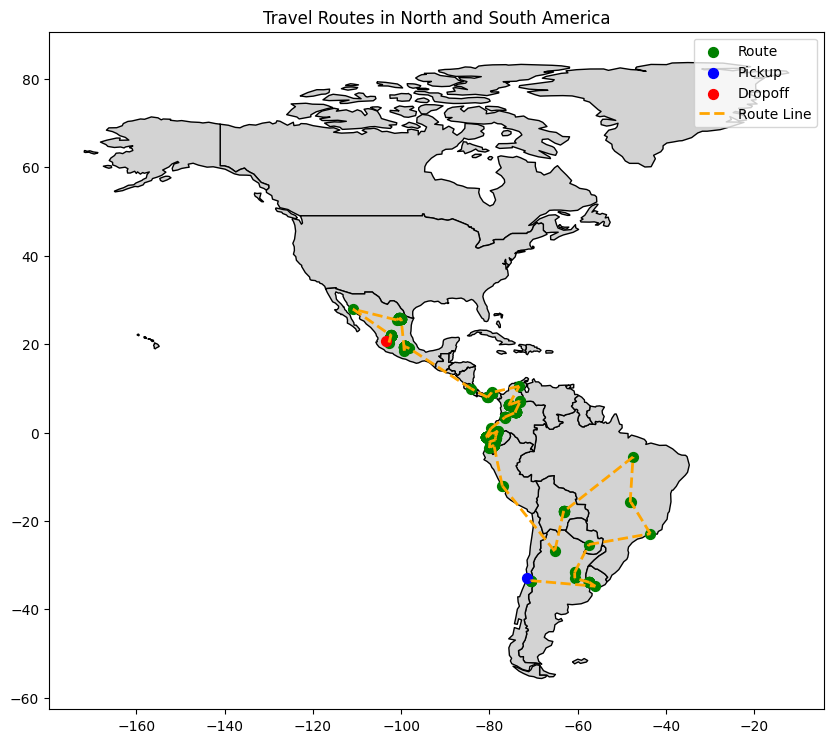

In [15]:
# Create a DataFrame with pickup and dropoff points
df_longlat = pd.DataFrame({
    'lat': df['dropoff_latitude'].tolist() + df['pickup_latitude'].tolist(),
    'long': df['dropoff_longitude'].tolist() + df['pickup_longitude'].tolist(),
})

# Define starting and ending coordinates
start_latitude = -32.799890909114  # Replace with the actual starting latitude
start_longitude = -71.4313619689893  # Replace with the actual starting longitude
end_latitude = 20.65374466  # Replace with the actual ending latitude
end_longitude = -103.40145068  # Replace with the actual ending longitude

# Function to find the nearest point to a given location
def find_nearest_point(current_lat, current_lon, visited):
    """
    Find the nearest point to a given location based on distances and a heuristic score.

    Parameters:
    - current_lat (float): Latitude of the current location.
    - current_lon (float): Longitude of the current location.
    - visited (Series): Boolean series indicating whether each point has been visited.

    Returns:
    Series: The nearest point as a Pandas Series.
    """
    valid_points = df_longlat[~visited]
    valid_points['distance_to_current'] = valid_points.apply(lambda row: calculate_distance(current_lat, current_lon, row['lat'], row['long']), axis=1)
    valid_points['distance_to_end'] = valid_points.apply(lambda row: calculate_distance(row['lat'], row['long'], end_latitude, end_longitude), axis=1)

    # Find the nearest point to the current location considering both distances and not visited
    if len(valid_points) > 0:
        valid_points['heuristic_score'] = valid_points['distance_to_current'].subtract(valid_points['distance_to_end'])

        # Filter points within the right boundary of South America
        valid_points = valid_points[valid_points['long'] <= -35]

        if len(valid_points) > 0:
            nearest_point = valid_points.loc[valid_points['heuristic_score'].idxmin()]
            return nearest_point
        else:
            return None
    else:
        return None

# Function to calculate the greedy travel route
def calculate_travel_route_greedy():
    """
    Calculate the greedy travel route from the starting location to the ending location.

    Returns:
    tuple: Two lists containing latitude and longitude values representing the travel route.
    """
    lat = []
    long = []
    visited = pd.Series([False] * len(df_longlat), name='visited')

    # Find the nearest point to the starting location
    nearest_start_point = find_nearest_point(start_latitude, start_longitude, visited)

    # Initialize variables
    path = 0
    current_lat = nearest_start_point['lat']
    current_lon = nearest_start_point['long']

    while True:
        nearest_point = find_nearest_point(current_lat, current_lon, visited)

        tolerance = 0.8  # Allowed tolerance to pick endpoint
        if abs(current_lat - end_latitude) < tolerance and abs(current_lon - end_longitude) < tolerance:
            return lat, long

        if nearest_point is None:
            break

        visited[nearest_point.name] = True
        lat.append(nearest_point['lat'])
        long.append(nearest_point['long'])
        path += nearest_point['distance_to_current']

        current_lat = nearest_point['lat']
        current_lon = nearest_point['long']

    return lat, long

# Calculate the travel route
lat, long = calculate_travel_route_greedy()

# Create a GeoDataFrame with pickup and dropoff points
geometry_pickup = [Point(start_longitude, start_latitude)]
geometry_dropoff = [Point(end_longitude, end_latitude)]

gdf_pickup = gpd.GeoDataFrame(geometry_pickup, geometry=geometry_pickup, crs="EPSG:4326")
gdf_dropoff = gpd.GeoDataFrame(geometry_dropoff, geometry=geometry_dropoff, crs="EPSG:4326")

# Create a GeoDataFrame for the travel route
geometry_route = [Point(lon, lat) for lon, lat in zip(long, lat)]
gdf_route = gpd.GeoDataFrame(geometry=geometry_route, crs="EPSG:4326")

# Create a GeoDataFrame for the line connecting the points in the route
line_geometry_list = [LineString([Point(lon1, lat1), Point(lon2, lat2)]) for lon1, lat1, lon2, lat2 in zip(long[:-1], lat[:-1], long[1:], lat[1:])]
gdf_route_line = gpd.GeoDataFrame(geometry=line_geometry_list, crs="EPSG:4326")

# Plotting
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
north_america = world[world['continent'] == 'North America']
south_america = world[world['continent'] == 'South America']

fig, ax = plt.subplots(figsize=(10, 10))
north_america.plot(ax=ax, color='lightgray', edgecolor='black')
south_america.plot(ax=ax, color='lightgray', edgecolor='black')
gdf_route.plot(ax=ax, color='green', markersize=50, label='Route')
gdf_pickup.plot(ax=ax, color='blue', markersize=50, label='Pickup')
gdf_dropoff.plot(ax=ax, color='red', markersize=50, label='Dropoff')
gdf_route_line.plot(ax=ax, color='orange', linestyle='--', linewidth=2, label='Route Line')

plt.title('Travel Routes in North and South America')
plt.legend()
plt.show()